<a href="https://colab.research.google.com/github/dlapushin/buyer_persona_maker/blob/main/title_func_level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) A Named Entity Recognition model for job title components

A Jupyter notebook for downloading an academic dataset of job titles and training a Naive Bayes classifier model that can tag any job title with a Level of Responsibility (e.g. Manager, VP) and its Function (e.g. Finance, Marketing, IT, Sales).

The dataset includes 475K job titles which have been parsed into their respective Levels of Responsibility (RES) and Functions (FUN).  Other components such as Location (LOC) and Stopping Words (O) are also included for completeness.

There are several data cleansing and enrichment steps included for data integrity purposes, which helps improve classification accuracy.  The original paper:

* *"IPOD: An Industrial and Professional Occupations Dataset and its Applications to Occupational Data Mining and Analysis"; Junhua Liu, Yung Chuen Ng, Kristin L. Wood, Kwan Hui Lim*

## 1. Load all required libraries and input data
* Will download and unzip a csv file with all job title and tagging data

In [ ]:
!pip -q install nltk

import pandas as pd
import numpy as np
import os
import requests
from zipfile import ZipFile
import subprocess
import pickle
import gc
import sys
import ipywidgets as widgets
from IPython.display import display,clear_output

import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

import seaborn as sns

def github_unzip(raw_url, filename):
    r = requests.get(raw_url, allow_redirects=True)
    f = open(filename,'wb')
    f.write(r.content)
    f.close()
    subprocess.run(["unzip", "-o", filename])

url = 'https://raw.githubusercontent.com/junhua/IPOD/ad55ddede065612a225628492698d540f3516440/data/JT_NER.csv.zip'
github_unzip(url, 'JT_NER_csv.zip')

df_corpus = pd.read_csv('NER_corpus_Collated_Positions_All_18June2020.csv')
print(df_corpus.shape)
df_corpus.head()

Archive:  JT_NER_csv.zip
  inflating: NER_corpus_Collated_Positions_All_18June2020.csv  
  inflating: __MACOSX/._NER_corpus_Collated_Positions_All_18June2020.csv  
(475073, 8)


,Original_Title,Processed_Title,Tag_A1,BIOES_Tag_A1,Tag_A2,BIOES_Tag_A2,Tag_A3,BIOES_Tag_A3
0,Senior Manager,senior manager,RES RES,B-RES E-RES,RES RES,B-RES E-RES,RES RES,B-RES E-RES
1,Financial Controller,financial controller,FUN RES,S-FUN S-RES,FUN RES,S-FUN S-RES,FUN RES,S-FUN S-RES
2,Acting Financial Controller,acting financial controller,RES FUN RES,S-RES S-FUN S-RES,RES FUN RES,S-RES S-FUN S-RES,RES FUN RES,S-RES S-FUN S-RES
3,Assistant Manager,assistant manager,RES RES,B-RES E-RES,RES RES,B-RES E-RES,RES RES,B-RES E-RES
4,Audit Senior,audit senior,FUN RES,S-FUN S-RES,FUN RES,S-FUN S-RES,FUN RES,S-FUN S-RES


## 2. Data transformations and enrichments
* Break out each title and particle of speech (pos) into constituent tokens
* Tokens are placed in dedicated fields and a dimension (length) field is also created to check consistency between number of tokens in title and number of pos's

    * title_split
    * pos_split_a1
    * pos_split_a2
    * pos_split_a3

This will help confirm and remove cases where special characters (e.g. *\t) have compromised the tagging - number of tokens != number of pos tags

In [ ]:
df_corpus['title_split'] = df_corpus.apply(lambda x: x['Processed_Title'].split(), axis=1)
df_corpus['title_split_len'] = df_corpus.apply(lambda x: len(x['title_split']), axis=1)

df_corpus['pos_split_a1'] = df_corpus.apply(lambda x: x['Tag_A1'].split(), axis=1)
df_corpus['pos_split_a1_len'] = df_corpus.apply(lambda x: len(x['pos_split_a1']), axis=1)

df_corpus['pos_split_a2'] = df_corpus.apply(lambda x: x['Tag_A2'].split(), axis=1)
df_corpus['pos_split_a2_len'] = df_corpus.apply(lambda x: len(x['pos_split_a2']), axis=1)

df_corpus['pos_split_a3'] = df_corpus.apply(lambda x: x['Tag_A3'].split(), axis=1)
df_corpus['pos_split_a3_len'] = df_corpus.apply(lambda x: len(x['pos_split_a3']), axis=1)

# find and remove cases where special characters (e.g. *\t) have compromised the tagging - number of tokens != number of pos tags

df_corpus_final = df_corpus[(df_corpus['title_split_len'] == df_corpus['pos_split_a1_len']) &
                           (df_corpus['pos_split_a1'] == df_corpus['pos_split_a2']) &
                           (df_corpus['pos_split_a1'] == df_corpus['pos_split_a3'])]

# each of the sum values should be equivalent for df_corpus_final at this point
print(sum(df_corpus_final['title_split_len']))
print(sum(df_corpus_final['pos_split_a1_len']))
print(sum(df_corpus_final['pos_split_a2_len']))
print(sum(df_corpus_final['pos_split_a3_len']))

1211417
1211417
1211417
1211417


## 3. Flatten each record (multiple pos tags) into individual records (one pos per record)
* Simplifies classification model training
* Each token becomes an entry in the training data (**X**) and each POS is used as an entry in the target variable (**y**)

In [ ]:
title_split = df_corpus_final['title_split'].explode('title_split')
title_split.reset_index(drop=True, inplace=True)

pos_split_a1 = df_corpus_final['pos_split_a1'].explode('pos_split_a1')
pos_split_a1.reset_index(drop=True, inplace = True)

df_flat = pd.concat([title_split, pos_split_a1], axis=1)
df_flat.columns = ['token','pos']  # rename columns
df_flat.reset_index(inplace=True, drop=True)
print('Flattened data frame has dimensions: ', str(df_flat.shape))

Flattened data frame has dimensions:  (1211417, 2)


## 4. Process and Enrich token / pos data

* Define functions to:
    * Confirm a stopword with the official nltk stopwords corpus
    * Create barchart plot of token counts for each POS: RES, FUN, LOC, and O
    * Create table with top n most frequent values for each POS
* Save backup file in case needed later
* Remove certain mis-labelled stop words to improve data integrity
* Create basic plot to compare token and pos counts, plus other metrics

In [ ]:
def create_pos_barchart(df):
    sns.set_theme()
    sns.set(rc={'figure.figsize':(8,5)})

    pos_counts = df.groupby('pos').count()
    pos_counts.reset_index(inplace=True)
    pos_counts.columns = ['pos','counts','stopwords']
    pos_counts.sort_values('counts', inplace=True, ascending=False)

    fig = sns.barplot(data=pos_counts, x='pos', y='counts')
    fig.set_xlabel('POS')
    fig.set_ylabel('Count')
    fig.set_title('POS Representation in IPOD Data Set (Enriched)',fontdict= {'fontsize': 18} )
    fig

def top_n_pos_token(df, top_n):

    token_counts_by_pos = pd.DataFrame(df.groupby(['pos','token']).size())
    token_counts_by_pos.reset_index(inplace=True)
    token_counts_by_pos.columns = ['pos','token','counts']

    df_top_n = pd.DataFrame()
    for pos in ['RES','FUN','O','LOC']:
        new_col = pd.DataFrame(token_counts_by_pos[token_counts_by_pos['pos'] == pos].sort_values('counts', ascending=False)[0:top_n][['token','counts']])
        new_col.reset_index(inplace=True, drop=True)
        df_top_n = pd.concat([df_top_n,new_col]
                             ,axis=1
                             ,ignore_index=True
                            )
    df_top_n.columns = ['RES', 'count', 'FUN', 'count', 'O', 'count', 'LOC', 'count']
    return df_top_n

def remove_mislabeled_stopwords(df, stop_words):
    df['stop_word'] = df['token'].apply(lambda x: '1' if x in stop_words else '0')
    indexStopword = df[(df['stop_word'] == '1') & (df['pos'] != 'O')].index
    df.drop(indexStopword, inplace=True)

    return df

def pos_split_override(df, token, pos):
    indexOverwrite = df[df['token'] == token].index
    df.loc[indexOverwrite,['pos']] = pos
    df_enriched = df
    return df_enriched

df_flat = pos_split_override(df_flat, 'it', 'FUN')
df_flat = pos_split_override(df_flat, 'ciso', 'RES')
df_flat = pos_split_override(df_flat, 'cmo', 'RES')
df_flat = pos_split_override(df_flat, 'sfdc', 'FUN')
df_flat = pos_split_override(df_flat, 'salesforce', 'FUN')
df_flat = pos_split_override(df_flat, 'sap', 'FUN')
df_flat = pos_split_override(df_flat, 'oracle', 'FUN')

for k in range(0,40): # creates additional needed training data

    df_flat = pd.concat([df_flat, pd.DataFrame({'token':'&','pos':'O'},index=[0])], ignore_index=True)
    df_flat = pd.concat([df_flat, pd.DataFrame({'token':'-','pos':'O'},index=[0])], ignore_index=True)
    df_flat = pd.concat([df_flat, pd.DataFrame({'token':'ciso','pos':'RES'},index=[0])], ignore_index=True)
    df_flat = pd.concat([df_flat, pd.DataFrame({'token':'sales','pos':'FUN'},index=[0])], ignore_index=True)

stop_words = set(stopwords.words('english'))  # create a searchable set of English stop words, but remove 'it' since that represents IT (info tech)
stop_words.remove('it')

df_flat.to_csv('position_title.csv')  # persist data to .csv file

df_flat_final = remove_mislabeled_stopwords(df_flat, stop_words)

## Unit test - should only result in 'O' value
df_flat_final[df_flat_final['stop_word'] == '1']['pos'].unique()

array(['O'], dtype=object)

### Barchart and Table
* RES and FUN tokens far outnumber stopwords (O) and locations (LOC)

,RES,count,FUN,count,O,count,LOC,count
0,manager,80348,business,17932,and,38327,asia,2239
1,senior,40895,project,16067,of,14916,apac,1687
2,engineer,34881,marketing,14849,for,1672,singapore,1462
3,director,31206,development,13351,to,1476,china,875
4,assistant,24631,operations,9988,the,1428,country,771
5,executive,21960,software,9390,summer,1411,east,681
6,analyst,18353,finance,8791,in,1167,south,675
7,consultant,16578,financial,7207,at,1166,sea,489
8,intern,15086,it,6898,i,864,north,433
9,associate,12167,technical,6868,rd,864,asean,424


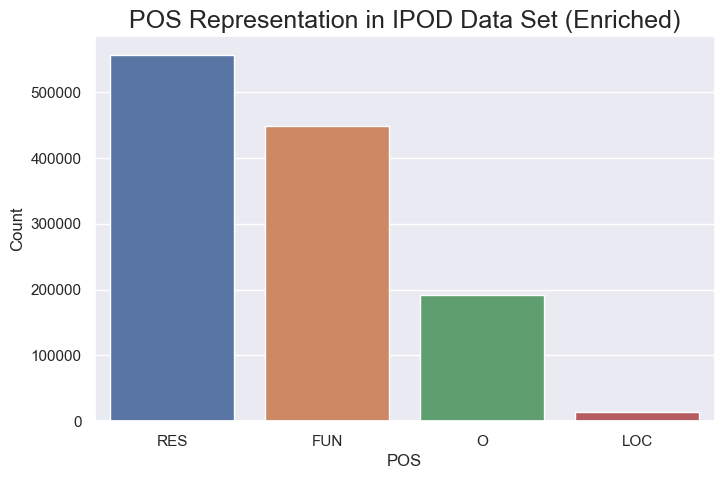

In [ ]:
create_pos_barchart(df_flat_final)
top_n_pos_token(df_flat_final, 10)

## 5. Train Machine Learning classifier model
* Create a 66% / 33% split for training and testing, using the **df_flat_final** dataset
* Train MultinomalNB classifier with X_train, y_train - **takes less than 1 min**
* Display accuracy score when done

In [ ]:
# Predicting the classification of a new token
def predict_category(token):
    token_features = vectorizer.transform([token])
    prediction = classifier.predict(token_features)
    return prediction[0]

train, test = train_test_split(df_flat_final, test_size=0.25, random_state=42)
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

# Format training data
training_data = df_flat_final[['token','pos']].values.tolist()

# Preparing the training features and labels
X_train = [data[0] for data in training_data]
y_train = [data[1] for data in training_data]

# Creating a CountVectorizer to convert text into numerical features
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

# Training the classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print('Accuracy score: {0:.1%}'. format(accuracy_score(y_test, y_pred)))

Training Data Shape: (908682, 3)
Testing Data Shape: (302895, 3)
Accuracy score: 98.1%


In [ ]:
from IPython.display import display

def jt_tokenized(job_title_text):

    df_job_title_breakdown = pd.DataFrame()

    for token in job_title_text.split(' '):
        predicted_category = predict_category(token.lower())
        df_job_title_breakdown = pd.concat([df_job_title_breakdown,
                                            pd.DataFrame({'token': token, 'pos': predicted_category}, index=[0])],
                                           axis=0, ignore_index=True)

    return df_job_title_breakdown

button = widgets.Button(description="Click Me!")
output = widgets.Output()

job_title = widgets.Text(
    value='type job title',
    placeholder='type job title',
    description='Enter title:',
    disabled=False
)

def on_button_clicked(b):
    with output:
        clear_output()
        #print("Button clicked.")
        html = widgets.HTML(#value="Hello <b>World</b>",
                            value = jt_tokenized(job_title.value).to_html(),
                            placeholder=str(job_title.value),
                            #description=jt_tokenized(job_title.value).to_html()
                            )
        display(html)

button.on_click(on_button_clicked)

top = widgets.HBox([job_title, button])
widgets.VBox([top, output])

### Serialize classifier model into pickle format

In [ ]:
file = open('title_classifier','wb')
pickle.dump(classifier,file)
file.close()

# 2) Buyer Persona Analytics (on CRM data)
* Introduces a **buyer_persona** class for uploading contact records (job title field at a minimum) from a CRM platform such as Salesforce.  
* Class includes **methods** for:
  * mapping of each job_title to its applicable Level of Responsibility (RES) and Function (FUN).
  * creating analytic views (heatmaps, parallel categories) on applicable buyer personas

**NOTE:** The code below can be run separately from prior sections since it only relies upon the pickle files created above.

## Load all required libraries and POS model from prior steps

In [ ]:
import os
import translate
import pickle5 as pickle
import string
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import plotly.express as px
from collections import Counter, OrderedDict
from tqdm import tqdm
tqdm.pandas()

with open('title_classifier_serial', 'rb') as f:
    classifier = pickle.load(f)

with open('vectorizer_serial', 'rb') as f:
    vectorizer = pickle.load(f)

## Class definition for Buyer_Persona

In [ ]:
class Buyer_Persona:

    def __init__(self):
        self.df = None

    def data_ingest(self, file_path, job_title_field):
        # Read the data from the given file_path into a pandas DataFrame
        # Assumes the file is either .csv or .xlsx
        if file_path.endswith(".csv"):
            print('Reading data file: ' + file_path)
            self.df = pd.read_csv(file_path, low_memory=False)
            self.df.drop(['Unnamed: 0'], axis=1, inplace=True)
        elif file_path.endswith(".xlsx"):
            self.df = pd.read_excel(file_path, low_memory=False)
            self.df.drop(['Unnamed: 0'], axis=1, inplace=True)
        else:
            raise ValueError("Unsupported file format. Please provide a .csv or .xlsx file.")

        # Validate if the job_title_field exists in the DataFrame
        if job_title_field not in self.df.columns:
            raise ValueError(f"Job title field '{job_title_field}' not found in the DataFrame.")

    def title_adjuster(self, job_title):
        translating = str.maketrans('', '', string.punctuation)
        title_adj = str.lower(str(job_title))
        title_adj = title_adj.translate(str.maketrans('', '', string.punctuation))

        return title_adj

    def title_clean(self, job_title_field):
        if self.df is None:
            raise ValueError("DataFrame is empty. Please use data_ingest to load data first.")
        print('Cleaning data in field: ' + job_title_field)

        clean_title_field = job_title_field + '_clean' ## creates new field based on the title field and adds "_clean"
        self.df[clean_title_field] = self.df[job_title_field].progress_apply(lambda x: self.title_adjuster(x))
        self.clean_title = clean_title_field

    def predict_category(self, token):
        token_features = vectorizer.transform([token])
        prediction = classifier.predict(token_features)

        return prediction[0]

    ## Create a master dictionary of all the tokens found in titles
    ## Predict the POS (RES or FUN) for each token
    ## Persist the resulting token:pos dictionary
    def master_token_to_odict(self):
        self.series_title = self.df[self.clean_title].tolist()

        print('Flattening tokens into list format:')
        self.master_token = []
        for t in tqdm(self.series_title):
            token_split_list = t.split(' ')

            for t_elem in token_split_list:
                self.master_token.append(t_elem.strip())

        self.odict_sorted = OrderedDict(Counter(self.master_token).most_common())

        print('Creating dictionary of token to POS:')
        self.odict_pos = {}
        for key in tqdm(self.odict_sorted):
            self.odict_pos[key] = {'count': self.odict_sorted[key],
                            'pos': self.predict_category(key)
                           }

    def jt_tokenized_dict(job_title_text):

        df_job_title_breakdown = pd.DataFrame()
        dict_pos = {'RES': [],
                    'FUN': []
                   }

        for token in job_title_text.split(' '):
            predicted_pos = predict_category(token.lower().str.strip())

            if(predicted_pos == 'RES'):
                dict_pos['RES'].append(token)
            if(predicted_pos == 'FUN'):
                dict_pos['FUN'].append(token)

        dict_pos['RES'] = ' '.join(sorted(dict_pos['RES']))
        dict_pos['FUN'] = ' '.join(sorted(dict_pos['FUN']))

        return dict_pos

    def tokenized_dict_to_col(df):

        dict_res_fun = jt_tokenized_dict(df['Title_adj'])
        df['RES'] = dict_res_fun['RES']
        df['FUN'] = dict_res_fun['FUN']
        return df

    def jt_tokenized_lists_v2(self, input_title_clean):
        RES = []
        FUN = []

        for token in input_title_clean.split(' '):

            try:
                predicted_pos = self.odict_pos[token]['pos']
            except:
                predicted_pos = None

            if(predicted_pos == 'RES'):
                RES.append(token)
            if(predicted_pos == 'FUN'):
                FUN.append(token)

        return [RES, FUN]

    def pos_mapper(self):
        # Apply the lambda function to the DataFrame
        print('Parsing field ' + self.clean_title + ' into RES and FUN components.  May take a few moments.')
        self.df = pd.concat([self.df, self.df.progress_apply(lambda x: self.jt_tokenized_lists_v2(x[self.clean_title]), axis=1, result_type = 'expand')], axis=1)
        self.df.rename(columns={0:'RES', 1:'FUN'}, inplace=True)
        self.df['RES_flat'] = self.df['RES'].progress_apply(lambda x: ' '.join(x))
        self.df['FUN_flat'] = self.df['FUN'].progress_apply(lambda x: ' '.join(x))

    def sorted_pos_token(self, pos):
        token_counts = pd.DataFrame(self.df.groupby(pos).size().sort_values(ascending=False))
        token_counts.reset_index(inplace=True)
        token_counts.columns = [pos, 'count']

        return token_counts

    def pos_sorter(self):
        print('Sorting RES and FUN values')
        self.list_res = list(self.sorted_pos_token('RES_flat')['RES_flat'])
        self.list_res.remove('')

        self.list_fun = list(self.sorted_pos_token('FUN_flat')['FUN_flat'])
        self.list_fun.remove('')

    def top_pos_sorter(self, n):
        print('Finding top RES and FUN values')

        self.top_res = self.list_res[0:n]
        self.top_fun = self.list_fun[0:n]

    def top_pos_match(self):

        filter_res = (self.df['RES_flat'].isin(self.top_res))
        filter_fun = (self.df['FUN_flat'].isin(self.top_fun))

        self.df_top_pos_matches = self.df[filter_res & filter_fun]
        self.df_top_pos_matches.reset_index(inplace=True, drop=True)

    def top_pos_match_pchart(self):

        self.df_list = self.df_top_pos_matches[['RES_flat','FUN_flat']]
        self.df_list.reset_index(inplace=True, drop=True)
        data = self.df_list.values.tolist()

        df = pd.DataFrame(data, columns = ['RES', 'FUN'])
        fig = px.parallel_categories(df)
        fig.update_layout(width = 1000,
                          height = 800,
                          title = 'Parallel categories for Top Responsibility Levels (RES) and Functions (FUN)')
        fig.show()

    def top_pos_match_heatmap(self):

        df_focus = self.df_top_pos_matches.groupby(['RES_flat','FUN_flat']).count().reset_index()[['RES_flat','FUN_flat','Title']]
        df_focus = df_focus.pivot(index='RES_flat', columns='FUN_flat')['Title'].fillna(0)

        fig = px.imshow(df_focus, x=new_df.columns, y=new_df.index, color_continuous_scale=px.colors.sequential.GnBu)
        fig.update_layout(width = 1000,
                          height = 1000,
                         title = 'Heatmap for top Responsibility Levels (RES) and Functions (FUN)')
        fig.update_xaxes(title_text='Top Functions (FUN)')
        fig.update_yaxes(title_text='Top Responsibility Levels (RES)')
        fig.show()


## Example usage pattern:
* Load contact records with a job title field included.  The job title field needs to be specified with the *data_ingest* method

In [ ]:
# Example usage:
buyer_persona = Buyer_Persona()  ## Instantiate the Buyer_Persona class
buyer_persona.data_ingest('my_crm_contacts.csv', 'Title')  ## Ingests contacts file; specify field containing job title (e.g. Title)
buyer_persona.title_clean('Title')  ## Strips punctutation and other extraneous text form job titles
buyer_persona.master_token_to_odict()  ## Creates master dictionary of tokens to part of speech (POS)

buyer_persona.pos_mapper()
buyer_persona.pos_sorter()
buyer_persona.top_pos_sorter(20)
buyer_persona.top_pos_match()

display(buyer_persona.top_pos_match_heatmap())
display(buyer_persona.top_pos_match_pchart())